In [1]:
import coralme
import pandas
from coralme.solver.solver import ME_NLP
import cobra
pandas.set_option('display.max_colwidth', None)

In [2]:
LB_essentiality = pandas.read_csv("./datasets/essentiality/knockouts.csv",sep="\t")
print("Dataset with {} entries".format(LB_essentiality.shape[0]))

Dataset with 54 entries


In [3]:
me = coralme.io.pickle.load_pickle_me_model("./pputidame/MEModel-step3-pputida-Keff.pkl")

In [4]:
medium = pandas.read_csv("./media/M9.txt",index_col="ID",comment="#")["Bound"]
def enforce_medium(model,medium):
    for r in model.reactions.query("^EX_"):
        r.lower_bound = 0
    for r,lb in medium.items():
        model.reactions.get_by_id(r).lower_bound = lb
enforce_medium(me,medium)

In [5]:
# model = cobra.io.load_json_model("./pputidame/inputs/m_model.json")

In [6]:
# Convert ME-model to NLP object
def get_nlp(model):
    # Call construct LP problem function from model to get precursor objects.
    # lamdify = True -> Creates lambdify functions to calculate bounds as a function of mu
    # per_position = True -> LB and UB bounds as list of lambdify instead of a lambdify to 
    # be able to change individual values
    Sf, Se, lb, ub, b, c, cs, atoms, lambdas, Lr, Lm = model.construct_lp_problem(lambdify=False,per_position=True)

    # Construct NLP object from precursor objects
    me_nlp = ME_NLP(Sf, Se,b, c, lb, ub,  cs, atoms, lambdas)
    return me_nlp
# Optimize NLP object
def get_feasibility(me_nlp, basis=None):
    x_new,y_new,z_new,stat_new,hs_new = me_nlp.solvelp(0.001,basis,'quad')
    return True if stat_new=="optimal" else False

def get_transcription(gene):
    return [r.id for r in gene.reactions if isinstance(r,coralme.core.reaction.TranscriptionReaction)]

def knockout_gene_transcription(nlp,gene,gene_to_transcription_dct,rxn_index_dct,met_index_dct):
    gene = f"RNA_{gene}"
    metabolite_index = met_index_dct[gene]
    for r in gene_to_transcription_dct[gene]:
        reaction_index = rxn_index_dct[r]
        coeff = nlp.Sf[(metabolite_index,reaction_index)]
        assert coeff == 1, f"Gene {gene} not in transcription reaction {r}?"
        nlp.Sf[(metabolite_index,reaction_index)] = 0

def knockout_gene_translation(nlp,gene,gene_to_transcription_dct,rxn_index_dct,met_index_dct):
    reaction = f"translation_{gene}"
    assert reaction in rxn_index_dct, f"Reaction {reaction} not in model?"
    reaction_index = rxn_index_dct[reaction]
    nlp.xl[reaction_index] = 0
    nlp.xu[reaction_index] = 0

In [7]:
# Get reaction and metabolite dictionaries
rxn_index_dct = {r.id : me.reactions.index(r) for r in me.reactions}
met_index_dct = {m.id : me.metabolites.index(m) for m in me.metabolites}
gene_to_transcription_dct = {m.id : get_transcription(m) for m in me.all_genes}

In [8]:
len(gene_to_transcription_dct)

1677

In [9]:
# Convert ME-model to NLP object
nlp = get_nlp(me)
assert get_feasibility(nlp)

### Run in pararallel

In [10]:
def job(nlp,gene,gene_to_transcription_dct,rxn_index_dct,met_index_dct):
    # knockout_gene_transcription(nlp,gene,gene_to_transcription_dct,rxn_index_dct,met_index_dct)
    knockout_gene_translation(nlp,gene,gene_to_transcription_dct,rxn_index_dct,met_index_dct)
    if get_feasibility(nlp):
        return (gene,1)
    return (gene,0)

In [11]:
run_for = [g.split("RNA_")[-1] for g in gene_to_transcription_dct]
# run_for = LB_essentiality["Gene ID"].values
# run_for = LB_essentiality[LB_essentiality["Model"]==0]["Gene ID"].values[:12]

In [12]:
import multiprocessing as mp
from tqdm import tqdm
import traceback
# Simulation in parallel using multiprocessing
NP = 10
pool = mp.Pool(min(NP,len(run_for)),maxtasksperchild=1)
pbar = tqdm(total=len(run_for),position=0,leave=True)
pbar.set_description('Building ({} threads)'.format(NP))
essentiality = pandas.Series()
def collect_result(result):
    essentiality[result[0]] = result[1]
    pbar.update(1)
def error_callback(e):
    traceback.print_exception(type(e), e, e.__traceback__)
for gene in run_for:
    args = (nlp,gene,gene_to_transcription_dct,rxn_index_dct,met_index_dct)
    kwargs = {}
    pool.apply_async(job,args=args,kwds=kwargs,callback=collect_result,error_callback=error_callback)
pool.close()
pool.join()

multiprocessing.pool.RemoteTraceback: | 40/1677 [07:17<2:45:20,  6.06s/it] 
"""
Traceback (most recent call last):
  File "/opt/miniconda3/envs/coralme-1.1.5/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_8000/28458887.py", line 3, in job
    knockout_gene_translation(nlp,gene,gene_to_transcription_dct,rxn_index_dct,met_index_dct)
  File "/tmp/ipykernel_8000/3719362770.py", line 31, in knockout_gene_translation
    assert reaction in rxn_index_dct, f"Reaction {reaction} not in model?"
AssertionError: Reaction translation_PP_16SA not in model?
"""

The above exception was the direct cause of the following exception:

AssertionError: Reaction translation_PP_16SA not in model?
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/miniconda3/envs/coralme-1.1.5/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipy

In [52]:
Results = pandas.concat([LB_essentiality.set_index("Gene ID"),essentiality.rename("ME")],axis=1)

In [53]:
Results.to_csv("./datasets/essentiality/ME-essentiality-translation.csv")

In [54]:
Results

,Gene Name,Model,Experiment,ME
PP_0082,trpA,0.0,0.0,0
PP_0184,argH,0.0,0.0,0
PP_0289,hisB,0.0,0.0,0
PP_0290,hisH,0.0,0.0,0
PP_0293,hisF,0.0,0.0,0
...,...,...,...,...
PP_5416,NaN,NaN,NaN,1
PP_5417,NaN,NaN,NaN,1
PP_5419,NaN,NaN,NaN,1
PP_5418,NaN,NaN,NaN,1


In [16]:
ComparableResults = Results.dropna(subset="Model")

In [25]:
def confusion(df,sample,ref):
    tp = df[(df[sample]==df[ref]) & (df[ref] == 1)]
    tn = df[(df[sample]==df[ref]) & (df[ref] == 0)]
    fp = df[(df[sample]!=df[ref]) & (df[ref] == 0)]
    fn = df[(df[sample]!=df[ref]) & (df[ref] == 1)]
    Accuracy = (tp.shape[0] + tn.shape[0])/df.shape[0]
    return tp.shape[0],tn.shape[0],fp.shape[0],fn.shape[0],Accuracy

In [27]:
confusion(ComparableResults,"Model","Experiment")

(4, 42, 3, 5, 0.8518518518518519)

In [28]:
confusion(ComparableResults,"ME","Experiment")

(4, 42, 3, 5, 0.8518518518518519)

In [42]:
functions = pandas.Series({g.id.split("RNA_")[-1]:list(g.functions)[0] for g in me.all_genes}).rename("Function")
functions

PP_0003                              Translation
PP_0008                            Transcription
PP_0026        Metabolic:S_Heavy_Metal_Tolerance
PP_0037    Metabolic:S_Transport__Outer_Membrane
PP_0041        Metabolic:S_Heavy_Metal_Tolerance
                           ...                  
PP_5416    Metabolic:S_Oxidative_Phosphorylation
PP_5417    Metabolic:S_Oxidative_Phosphorylation
PP_5418    Metabolic:S_Oxidative_Phosphorylation
PP_5419    Metabolic:S_Oxidative_Phosphorylation
PP_5420    Metabolic:S_Oxidative_Phosphorylation
Name: Function, Length: 1677, dtype: object

In [45]:
AnnotatedResults = pandas.concat([Results,functions],axis=1).dropna(subset="ME")

<Axes: ylabel='count'>

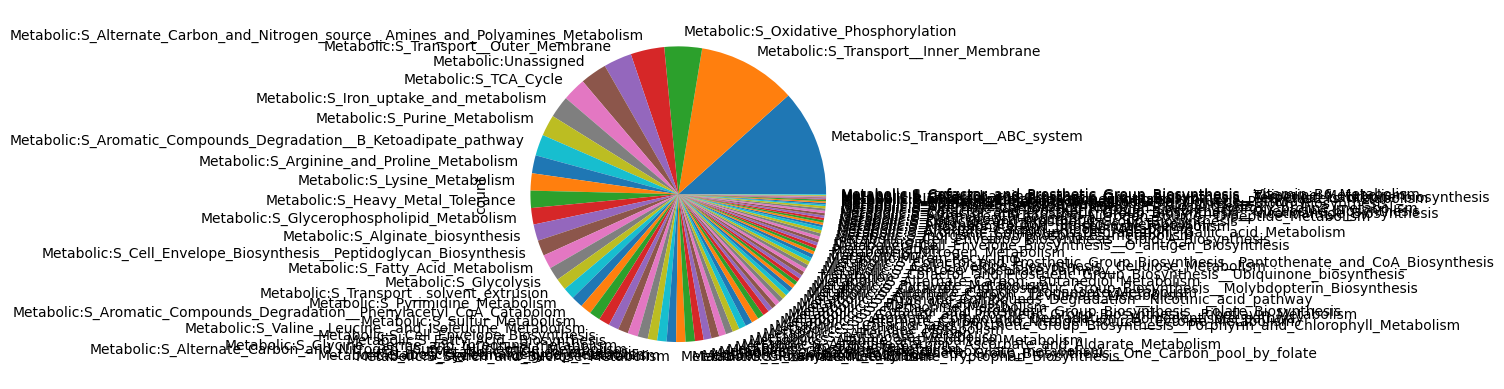

In [49]:
AnnotatedResults[AnnotatedResults["ME"] == 1]["Function"].value_counts().plot.pie()

In [58]:
AnnotatedResults.to_csv("datasets/GeneEssentialityRessults-Annotated.csv")